# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
1. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

**Обратите внимание**: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Описание данных
Таблица *users* (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица *calls* (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица *messages* (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица *internet* (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица *tariffs* (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файлы с данными и изучите общую информацию

In [1]:
# Импорт нужных библиотек и классов
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthBegin

In [2]:
# Открываем файлы с данными
users_df = pd.read_csv('datasets/users.csv')
calls_df = pd.read_csv('datasets/calls.csv')
messages_df = pd.read_csv('datasets/messages.csv')
internet_df = pd.read_csv('datasets/internet.csv')
tariffs_df = pd.read_csv('datasets/tariffs.csv')

In [3]:
# Датасет с тарифами
print(tariffs_df.head())
tariffs_df.info()

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [4]:
# Датасет с пользователями
print(users_df.head())
users_df.info()

   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
# Датасет со звонками
print(calls_df.head())
print('\nКоличество строк с нулевой длительностью звонка:', len(calls_df[calls_df['duration'] == 0.00]), '\n')
calls_df.info()

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

Количество строк с нулевой длительностью звонка: 39613 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
# Датасет с сообщениями
print(messages_df.head())
messages_df.info()

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
# Датасет с интернетом
print(internet_df.head())
print('\nКоличество строк с нулевым трафиком внутри сессии:', len(internet_df[internet_df['mb_used'] == 0.0]), '\n')
internet_df.info()

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000

Количество строк с нулевым трафиком внутри сессии: 19598 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


### Вывод по Шагу 1.
1. По тарифам датасет состоит из двух строк, все столбцы нужного типа.
2. По пользователям можно привести столбцы reg_date и churn_date к типу datetime.
3. По звонкам видим, что столбец call_date можно привести к типу datetime. Также много записей с длительностью звонка 0.00. 
4. По сообщениям столбец message_date можно перевести в datetime.
5. По интернету можно избавиться от столбца Unnamed: 0, т.к. он дублирует информацию в индексе и привести session_date к типу datetime. Также присутствует много записей с нулевым трафиком.

### Шаг 2. Подготовьте данные

In [8]:
# Привести данные к нужным типам
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format = '%Y.%m.%d')
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format = '%Y.%m.%d', errors='coerce')
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format = '%Y.%m.%d')
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format = '%Y.%m.%d')
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format = '%Y.%m.%d')

Будем считать что звонки с нулевой длительностью и интернет-сессии с нулевым трафиком возникли из-за сбоя оборудования. Чтобы не удалять такие строки будем считать эти звонки равными 1 минуте, а интернет-сессии 1 МБ, т.к. факт звонка и интернет-соединения всё равно установлён. Также округлим вверх все звонки с точностью до 1 минуты и трафик до 1 МБ. Это позволит нам поменять тип данных на целочисленный.

In [9]:
# Исправить ошибки в данных
calls_df['duration'] = (calls_df['duration'] + 0.001).apply(np.ceil)
calls_df['duration'] = calls_df['duration'].astype('int')
internet_df['mb_used'] = (internet_df['mb_used'] + 0.001).apply(np.ceil)
internet_df['mb_used'] = internet_df['mb_used'].astype('int')
internet_df.drop(columns=['Unnamed: 0'], inplace=True)
# Переименуем столбец с названием тарифа в таблице пользователей для единообразия
users_df.rename(columns={"tariff" : "tariff_name"}, inplace = True)

Посчитайте для каждого пользователя:
- **количество сделанных звонков и израсходованных минут разговора по месяцам:**

In [10]:
# На основе call_date вычисляем month
calls_df['month'] = calls_df['call_date'] - MonthBegin(1)
# Формируем таблицу звонков сгруппированную по user_id и month
calls_grouped = calls_df[['user_id', 'month', 'duration']].groupby(['user_id', 'month']).agg(['sum','count'])
calls_grouped.reset_index(inplace=True)
calls_grouped.columns = ['user_id', 'month', 'call_duration', 'call_count']

print('calls_grouped:\n', calls_grouped.head(), '\n')

calls_grouped:
    user_id      month  call_duration  call_count
0     1000 2018-05-01            164          22
1     1000 2018-06-01            187          43
2     1000 2018-07-01            350          49
3     1000 2018-08-01            415          50
4     1000 2018-09-01            501          60 



- **количество отправленных сообщений по месяцам:**

In [11]:
# На основе message_date вычисляем month
messages_df['month'] = messages_df['message_date'] - MonthBegin(1)
# Формируем таблицу звонков сгруппированную по user_id и month
messages_grouped = messages_df[['user_id', 'month', 'id']].groupby(['user_id', 'month']).agg(['count'])
messages_grouped.reset_index(inplace=True)
messages_grouped.columns = ['user_id', 'month', 'message_count']

print('messages_grouped:\n', messages_grouped.head(), '\n')

messages_grouped:
    user_id      month  message_count
0     1000 2018-05-01             24
1     1000 2018-06-01             60
2     1000 2018-07-01             74
3     1000 2018-08-01             81
4     1000 2018-09-01             59 



- **объем израсходованного интернет-трафика по месяцам:**

In [12]:
# На основе session_date вычисляем month
internet_df['month'] = internet_df['session_date'] - MonthBegin(1)
# Формируем таблицу звонков сгруппированную по user_id и month
internet_grouped = internet_df.groupby(['user_id', 'month']).sum()
internet_grouped.reset_index(inplace=True)

print('internet_grouped:\n', internet_grouped.head(), '\n')

internet_grouped:
    user_id      month  mb_used
0     1000 2018-05-01     3870
1     1000 2018-06-01    21649
2     1000 2018-07-01    14017
3     1000 2018-08-01    14621
4     1000 2018-09-01    14034 



- **помесячную выручку с каждого пользователя:**  

Для этого сначала сформируем общую таблицу по всем таблицам, а затем вычислим выручку.

In [13]:
summary_table = (
    calls_grouped
    .merge(messages_grouped, on=['user_id', 'month'])
    .merge(internet_grouped, on=['user_id', 'month'])
    .merge(users_df, on=['user_id'])
    .merge(tariffs_df, on=['tariff_name'])
)

In [14]:
# Метод поиска месячной выручки по пользователям
def calc_month_revenue_by_user(row):
    revenue = row['rub_monthly_fee']
    
    if(row['call_duration'] > row['minutes_included']):
        revenue += (row['call_duration'] - row['minutes_included']) * row['rub_per_minute']
    
    if(row['message_count'] > row['messages_included']):
        revenue += (row['message_count'] - row['messages_included']) * row['rub_per_message']
        
    if(row['mb_used'] > row['mb_per_month_included']):
        over_norm_gb_used = int(np.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024.0))
        revenue += over_norm_gb_used * row['rub_per_gb']
    
    return revenue

In [15]:
summary_table['month_revenue'] = summary_table.apply(calc_month_revenue_by_user, axis = 1)

### Шаг 3. Проанализируйте данные

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение.

In [16]:
# Разделим данные по тарифам
summary_table_smart = summary_table.query('tariff_name == "smart"')
summary_table_ultra = summary_table.query('tariff_name == "ultra"')

Рассмотрим отдельно тариф **Smart**:

In [17]:
print(summary_table_smart[['call_duration', 'message_count', 'mb_used']].describe())
print('\nvariance:\n', summary_table_smart[['call_duration', 'message_count', 'mb_used']].var())

       call_duration  message_count       mb_used
count    1919.000000    1919.000000   1919.000000
mean      431.846274      38.686816  16230.001042
std       189.755610      26.642467   5705.828208
min         1.000000       1.000000    203.000000
25%       294.000000      17.000000  12642.500000
50%       438.000000      34.000000  16326.000000
75%       560.500000      55.000000  20128.500000
max      1429.000000     143.000000  37653.000000

variance:
 call_duration    3.600719e+04
message_count    7.098211e+02
mb_used          3.255648e+07
dtype: float64


По тарифу **Smart** получаем:

1) по звонкам:
    - среднее 431.846, дисперсия 36007, стандартное отклонение 189.756
2) по сообщениям:
    - среднее 38.687, дисперсия 709.82, стандартное отклонение 26.642
2) по интернет-трафику:
    - среднее 16230, дисперсия 32556480, стандартное отклонение 5705.828

Рассмотрим отдельно тариф **Ultra**:

In [18]:
print(summary_table_ultra[['call_duration', 'message_count', 'mb_used']].describe())
print('\nvariance:\n', summary_table_ultra[['call_duration', 'message_count', 'mb_used']].var())

       call_duration  message_count       mb_used
count     755.000000     755.000000    755.000000
mean      570.193377      61.376159  19536.907285
std       318.265891      44.602833   9546.139924
min         1.000000       1.000000      1.000000
25%       339.000000      25.000000  12145.000000
50%       556.000000      53.000000  19585.000000
75%       778.000000      88.000000  26372.000000
max      1693.000000     230.000000  47117.000000

variance:
 call_duration    1.012932e+05
message_count    1.989413e+03
mb_used          9.112879e+07
dtype: float64


По тарифу **Ultra** получаем:

1) по звонкам:
    - среднее 570.2, дисперсия 101293.2, стандартное отклонение 318.266
2) по сообщениям:
    - среднее 61.376, дисперсия 1989.4, стандартное отклонение 44.6
2) по интернет-трафику:
    - среднее 19536.9, дисперсия 91128790, стандартное отклонение 9546.14

Постройте гистограммы. Опишите распределения.

In [19]:
# Функция для построения гистограммы
def create_hist(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    plt.figure(figsize=(9,5))
    sns.distplot(df[column_name], bins=10, hist_kws={"range":(Q1-3*IQR, Q3+3*IQR)})
    plt.show()

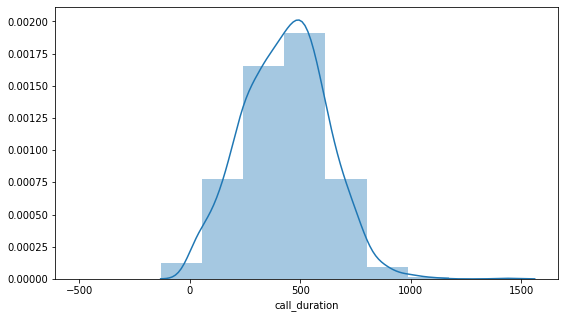

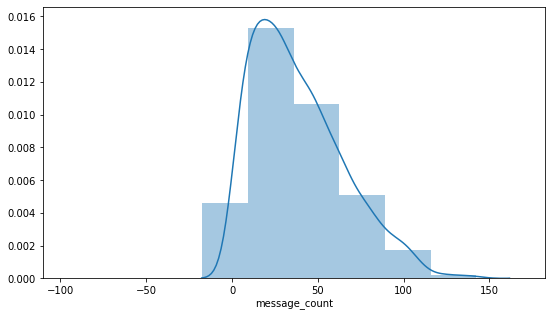

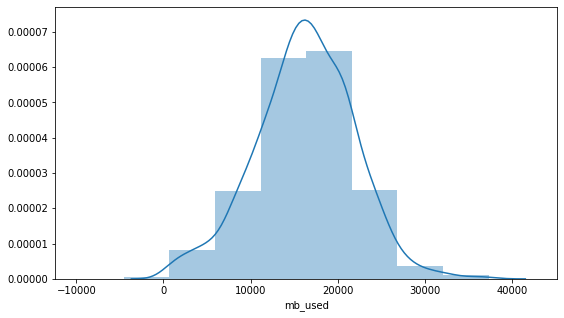

In [20]:
for col in ['call_duration', 'message_count', 'mb_used']:
    create_hist(summary_table_smart, col)

По тарифу **Smart** видим, что распределения похожи на нормальные, но в случае с разговорами и сообщениями датасет скошен влево, а в случае с интернет-трафиком вправо.

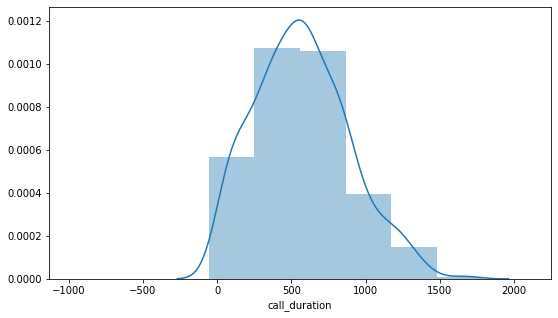

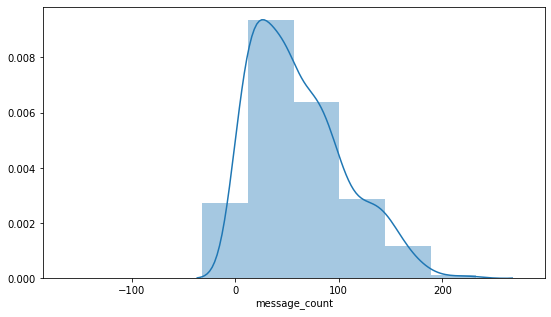

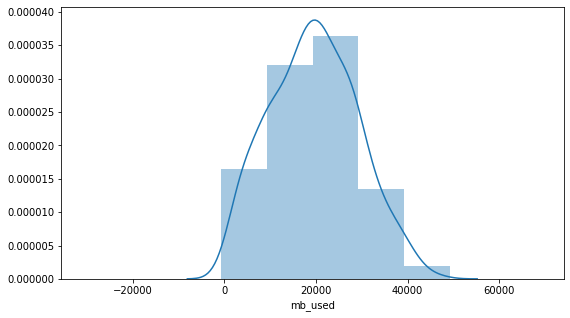

In [21]:
for col in ['call_duration', 'message_count', 'mb_used']:
    create_hist(summary_table_ultra, col)

По тарифу **Ultra** видим, что распределения похожи на нормальные и все три распределения скошены влево.

### Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:

Воспользуемся гипотезой о равенстве средних двух генеральных совокупностей.

In [22]:
# Найдем среднее значение выручки по двум тарифам
print('Средняя выручка в месяц по тарифу Smart:', (int)(summary_table_smart['month_revenue'].mean()))
print('Средняя выручка в месяц по тарифу Ultra:', (int)(summary_table_ultra['month_revenue'].mean()))

Средняя выручка в месяц по тарифу Smart: 1296
Средняя выручка в месяц по тарифу Ultra: 2046


Видим что средние значения отличаются. Но для проверки гипотезы надо провести статистический тест.  
Для его выполнения надо узнать отличаются ли дисперсии выборок.

In [23]:
# Найдем дисперсию выручки по двум тарифам
print('Дисперсия месячной выручки по тарифу Smart:', (int)(summary_table_smart['month_revenue'].var()))
print('Дисперсия месячной выручки по тарифу Ultra:', (int)(summary_table_ultra['month_revenue'].var()))

Дисперсия месячной выручки по тарифу Smart: 665571
Дисперсия месячной выручки по тарифу Ultra: 101535


Видим что дисперсии отличаются - значит параметр equal_var в метод ttest_ind надо будет передавать со значением False.  
Нулевой гипотезой в нашем случае будет равенство средних выручек по 2 тарифам.

In [24]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    summary_table_smart['month_revenue'], 
    summary_table_ultra['month_revenue'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.7814365433054714e-213
Отвергаем нулевую гипотезу


**Вывод**  
Приходим к выводу, что средние выручки по тарифам различаются - в нашем случае это была альтернативная гипотеза. Судя по средней выручке тариф Ultra приносит больше денег, чем Smart.

- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:

In [25]:
summary_table_moscow = summary_table.query('city == "Москва"')
summary_table_other_cities = summary_table.query('city != "Москва"')

In [26]:
# Найдем среднее значение выручки по Москве и неМоскве
print('Средняя выручка в месяц по Москве:', (int)(summary_table_moscow['month_revenue'].mean()))
print('Средняя выручка в месяц по остальным городам:', (int)(summary_table_other_cities['month_revenue'].mean()))

Средняя выручка в месяц по Москве: 1559
Средняя выручка в месяц по остальным городам: 1496


На первый взгляд выручка примерно одинаковая.

In [27]:
# Найдем дисперсию выручки
print('Дисперсия месячной выручки по Москве:', (int)(summary_table_moscow['month_revenue'].var()))
print('Дисперсия месячной выручки по остальным городам:', (int)(summary_table_other_cities['month_revenue'].var()))

Дисперсия месячной выручки по Москве: 568372
Дисперсия месячной выручки по остальным городам: 631745


Дисперсии неравны - значит параметр equal_var тоже будет False.  
Формируем нулевую гипотезу -- по Москве и другим городам выручки равны.

In [28]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    summary_table_moscow['month_revenue'], 
    summary_table_other_cities['month_revenue'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10155174540806766
Не получилось отвергнуть нулевую гипотезу


**Вывод**  
Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

### Общий вывод

В этом проекте была проанализирована выборка пользователей двух тарифов "Ультра" и "Смарт" компании Мегалайн за 2018 год.  
В ходе работы выяснили что:
1. Средняя выручка тарифа "Ультра" больше средней выручки тарифа "Смарт". Значит первый тариф приносит больше денег компании.
2. Звонки, Sms-сообщения и интернет-трафик имеют распределение близкое к нормальному (на обоих тарифах)
3. Средняя выручка в Москве примерно равна средней выручке по другим городам.